In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from src import display
from src import data_transformer as dt
from src.evaluation import jaccard, non_max_suppression, PredBoundingBox, MAP
from src.augmentations import RandomHorizontalFlip, RandomContrast

In [3]:
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [93]:
IMG_PATH = "./data/VOCdevkit/VOC2012/JPEGImages/"
train_json_path = "./data/VOCdevkit/VOC2012/cocoformatJson/voc_2012_train.json"
val_json_path = "./data/VOCdevkit/VOC2012/cocoformatJson/voc_2012_val.json"

In [94]:
target_size = 224

seed = 42
device = "cuda"

In [95]:
# data_list = []
# id_cat, temp_list = dt.load_pascal(train_json_path)
# data_list += temp_list
# _, temp_list = dt.load_pascal(val_json_path)
# data_list += temp_list

# random.seed(seed)
# random.shuffle(data_list)

In [101]:
id_cat, train_data_list = dt.load_pascal(train_json_path)

_, val_data_list = dt.load_pascal(val_json_path)


random.seed(seed)
random.shuffle(train_data_list)

In [102]:
train_data_list = dt.rescale_bounding_boxes(train_data_list, target_size)
train_data_list = dt.convert_to_center(train_data_list)

In [103]:
val_data_list = dt.rescale_bounding_boxes(val_data_list, target_size)
val_data_list = dt.convert_to_center(val_data_list)

In [104]:
example = train_data_list[0]
example

ImageEntry(filename='2009_004759.jpg', width=500, height=335, classnames=['motorbike', 'motorbike', 'person'], class_id=[13, 13, 14], bounding_boxes=[[113.0, 124.0, 210, 186], [51.0, 97.5, 46, 59], [20.5, 90.0, 13, 62]])

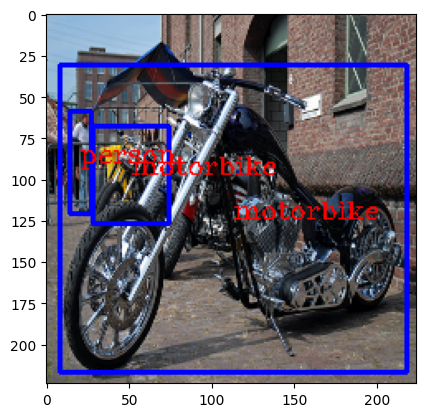

In [105]:
img_str = IMG_PATH + example.filename
img = display.read_img(img_str, target_size)

img = display.draw_boxes(img, example.bounding_boxes)
img = display.draw_text(img, example.classnames, example.bounding_boxes)
plt.imshow(img)
plt.show()

In [106]:
anchor_grid = [7, 4, 2, 1] # Number of grid-elements per dimension
anchor_zooms = [0.7, 1.0, 1.3] # How much bigger/smaller each default box will be (percentage)
anchor_ratios = [(1.0, 1.0), (1.0, 0.5), (0.5, 1.0)] # Ratio between (width, height)

anchor_scales = [(anc*h, anc*w) for anc in anchor_zooms for (h,w) in anchor_ratios]
anchor_offsets = [1/(2*o) for o in anchor_grid]
num_boxes = len(anchor_scales)

In [107]:
anchor_x = [np.repeat(np.linspace(ao, 1-ao, ag), ag) for (ao, ag) in zip(anchor_offsets, anchor_grid)]
anchor_x = np.concatenate(anchor_x)

anchor_y = [np.tile(np.linspace(ao, 1-ao, ag), ag) for ao,ag in zip(anchor_offsets, anchor_grid)]
anchor_y = np.concatenate(anchor_y)

anchor_centers = np.repeat(np.stack([anchor_x, anchor_y], axis=1), num_boxes, axis=0)

In [108]:
anchor_sizes  = [np.array([[w/ag, h/ag] for _ in range(ag**2) for w, h in anchor_scales])
                 for ag in anchor_grid]
anchor_sizes = np.concatenate(anchor_sizes)

anchors = np.concatenate([anchor_centers, anchor_sizes], axis=1)
anchors = torch.from_numpy(anchors).float()
anchors = anchors.to(device)

In [109]:
class PascalData(Dataset):
    def __init__(self, data_list_, target_size_=target_size, path_=IMG_PATH, p=0.5, train_mode=False):
        self.target_size = target_size_
        self.path = path_
        self.data_list = data_list_
        self.p = p

        self.mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

        self.train_mode = train_mode
        self.flip = RandomHorizontalFlip(p)
        self.contrast = RandomContrast(p)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]

        img_str = self.path + item.filename
        img = display.read_img(img_str, self.target_size)
        img = img / 255.0

        gt = np.vstack(item.bounding_boxes)

        if self.train_mode:
            img = self.contrast(img)
            img, gt = self.flip(img, gt)

        img = img.transpose((2, 0, 1))
        img = (img - self.mean) / self.std
        img = torch.from_numpy(img).float().to(device)

        #gt = gt / target_size
        gt = torch.from_numpy(gt).float() / self.target_size
        gt = gt[None, :, :].to(device)

        c = np.array(item.class_id) + 1
        c = torch.from_numpy(np.array(item.class_id)) + 1
        c = c[None, :].to(device)

        return (img, gt, c)

def collate_fn(batch):
    """
    Writing custom collector function since the Dataset class returns both tensors and lists.
    """

    x = [b[0] for b in batch]
    x = torch.stack(x, dim=0)
    gt = [b[1] for b in batch]
    c = [b[2] for b in batch]
    return (x, gt, c)

In [110]:
batch_size = 128

train_dataset = PascalData(train_data_list, train_mode=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

val_dataset = PascalData(val_data_list)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [111]:
class StandardConv(nn.Module):
    def __init__(self, in_channels, out_channels, p, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=p)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x

class UpsampleModule(nn.Module):
    def __init__(self, in_channels, out_channels, p, scale_factor=2):
        super().__init__()
        self.conv = StandardConv(out_channels, out_channels, p, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")

    def forward(self, x, x_upsample):
        x = self.upsample(x_upsample) + x
        x = self.conv(x)
        return x

class FPN(nn.Module):
    def __init__(self, p):
        super().__init__()

        pretrained_model = list(models.resnet34(pretrained='imagenet').children())[:-2]
        self.backbone = nn.Sequential(*pretrained_model)
        self.backbone_dropout = nn.Dropout2d(p=p[0])

        self.std_conv = nn.ModuleList([StandardConv(512, 256, p[1], stride=1),
                                       StandardConv(256, 256, p[1]),
                                       StandardConv(256, 256, p[1]),
                                       StandardConv(256, 256, p[1])
        ])

        self.upsample = nn.ModuleList([UpsampleModule(256, 256, p[1]),
                                       UpsampleModule(256, 256, p[1]),
                                       UpsampleModule(256, 256, p[1], scale_factor=7/4)
            
        ])

    def forward(self, x):
        x = self.backbone(x)
        x = self.backbone_dropout(x)
        x = self.std_conv[0](x)

        x7 = x.clone()
        x4 = self.std_conv[1](x7)
        x2 = self.std_conv[2](x4)
        x1 = self.std_conv[3](x2)

        x_upsample_2 = self.upsample[0](x2, x1)
        x_upsample_4 = self.upsample[1](x4, x_upsample_2)
        x_upsample_7 = self.upsample[2](x7, x_upsample_4)

        return (x_upsample_7, x_upsample_4, x_upsample_2, x1)

    def change_freezing(self, mode=False):
        for param in self.backbone.parameters():
            param.requires_grad = mode

    def train(self, mode=True):
        super().train(mode)

        # Avoid updating BN stats
        for m in self.backbone.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

class OutputConv(nn.Module):
    def __init__(self, in_channels, num_boxes):
        super().__init__()
        self.num_boxes = num_boxes
        self.conv_1 = nn.Conv2d(in_channels, (len(id_cat) + 1) * self.num_boxes, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels, 4 * self.num_boxes, kernel_size=3, padding=1)

    def flatten_conv(self, x):
        samples, channels, _, _ = x.size()
        x = x.permute(0, 2, 3, 1).contiguous()
        return x.view(samples, -1, int(channels / self.num_boxes))

    def forward(self, x):
        # [class predictions, box coordinates]
        return [self.flatten_conv(self.conv_1(x)), 
                self.flatten_conv(self.conv_2(x))]

class RetinaNet(nn.Module):
    def __init__(self, num_boxes, p):
        super().__init__()
        self.fpn = FPN(p)
        self.fpn.change_freezing(False)

        self.out_conv = nn.ModuleList([
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes)
        ])

    def forward(self, x):
        fpn_out = self.fpn(x)

        output_class_7, output_bb_7 = self.out_conv[0](fpn_out[0])
        output_class_4, output_bb_4 = self.out_conv[1](fpn_out[1])
        output_class_2, output_bb_2 = self.out_conv[2](fpn_out[2])
        output_class_1, output_bb_1 = self.out_conv[3](fpn_out[3])

        return [torch.cat([output_class_7, output_class_4, output_class_2, output_class_1], dim=1),
                torch.cat([output_bb_7, output_bb_4, output_bb_2, output_bb_1], dim=1)
               ]

In [112]:
def find_overlap(bb_true_i, anchors, jaccard_overlap):
    jaccard_tensor = jaccard(anchors, bb_true_i)
    _, max_overlap = torch.max(jaccard_tensor, dim=0)
    
    overlap_list = []    
    for i in range(len(bb_true_i)):
        threshold_overlap = (jaccard_tensor[:, i] > jaccard_overlap).nonzero()

        if len(threshold_overlap) > 0:
            threshold_overlap = threshold_overlap[:, 0]
            overlap = torch.cat([max_overlap[i].view(1), threshold_overlap])
            overlap = torch.unique(overlap)     
        else:
            overlap = max_overlap[i].view(1)
        overlap_list.append(overlap)
    return overlap_list

In [113]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, eps=1e-10):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps

    def forward(self, input, target):
        p = torch.sigmoid(input)
        pt = p * target.float() + (1.0 - p) * (1 - target).float()
        alpha_t = (1.0 - self.alpha) * target.float() + self.alpha * (1 - target).float()
        loss = - 1.0 * torch.pow((1 - pt), self.gamma) * torch.log(pt + self.eps)
        return loss.sum()

In [20]:
class Loss(nn.Module):
    def __init__(self, loc_factor, anchors, jaccard_overlap, **kwargs):
        super().__init__()
        self.fl = FocalLoss(**kwargs)
        self.loc_factor = loc_factor
        self.jaccard_overlap = jaccard_overlap
        self.anchors = anchors

    @staticmethod
    def one_hot_encoding(labels, num_classes):
        return torch.eye(num_classes)[labels.cpu()]

    @staticmethod
    def loc_transformation(x, anchors, overlap_indicies):
        # Doing location transformations according to SSD paper
        return torch.cat([(x[:, 0:1] - anchors[overlap_indicies, 0:1]) / anchors[overlap_indicies, 2:3],
                          (x[:, 1:2] - anchors[overlap_indicies, 1:2]) / anchors[overlap_indicies, 3:4],
                          torch.log((x[:, 2:3] / anchors[overlap_indicies, 2:3])),
                          torch.log((x[:, 3:4] / anchors[overlap_indicies, 3:4]))
                         ], dim=1)

    def forward(self, class_hat, bb_hat, class_true, bb_true):        
        loc_loss = 0.0
        class_loss = 0.0

        for i in range(len(class_true)):  # Batch level
            class_hat_i = class_hat[i, :, :]
            bb_true_i = bb_true[i]
            class_true_i = class_true[i]
            class_target = torch.zeros(class_hat_i.shape[0]).long().to(device)

            overlap_list = find_overlap(bb_true_i.squeeze(0), self.anchors, self.jaccard_overlap)

            temp_loc_loss = 0.0
            for j in range(len(overlap_list)):  # BB level
                overlap = overlap_list[j]
                class_target[overlap] = class_true_i[0, j]

                input_ = bb_hat[i, overlap, :]
                target_ = Loss.loc_transformation(bb_true_i[0, j, :].expand((len(overlap), 4)), self.anchors, overlap)

                temp_loc_loss += F.smooth_l1_loss(input=input_, target=target_, reduction="sum") / len(overlap)
            loc_loss += temp_loc_loss / class_true_i.shape[1]

            class_target = Loss.one_hot_encoding(class_target, len(id_cat) + 1).float().to(device)
            class_loss += self.fl(class_hat_i, class_target) / class_true_i.shape[1]

        loc_loss = loc_loss / len(class_true)
        class_loss = class_loss / len(class_true)
        loss = class_loss + loc_loss * self.loc_factor

        return loss, loc_loss, class_loss

In [21]:
loc_factor = 10.0
jaccard_overlap = 0.6

loss = Loss(loc_factor=loc_factor, anchors=anchors, jaccard_overlap=jaccard_overlap)

In [22]:
p = [0.2, 0.5]

torch.manual_seed(seed)
model = RetinaNet(num_boxes=num_boxes, p=p).to(device)

c:\Users\quang\anaconda3\envs\ailab\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\quang\anaconda3\envs\ailab\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
n_epochs = 50
lr = 1e-3
wd = 1e-2

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

In [24]:
jaccard_threshold = 0.5
map_eval = MAP(model, val_dataset, jaccard_threshold, anchors)

In [25]:
torch.manual_seed(seed)
random.seed(seed)
for epoch in range(n_epochs+1):
    model.train()

    train_loss, train_loc_loss, train_class_loss  = 0.0, 0.0, 0.0
    for _, (x, bb_true, class_true) in enumerate(train_loader):
        model.zero_grad()
        class_hat, bb_hat = model(x)

        batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, class_true, bb_true)
        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss.detach().cpu().numpy()
        train_class_loss += batch_class.detach().cpu().numpy()
        train_loc_loss += batch_loc.detach().cpu().numpy()

    train_loss =  np.round(train_loss / len(train_loader), 6)
    train_loc_loss =  np.round(train_loc_loss / len(train_loader), 6)
    train_class_loss =  np.round(train_class_loss / len(train_loader), 6)

    val_loss, val_loc_loss, val_class_loss = 0.0, 0.0, 0.0
    for _, (x, bb_true, class_true) in enumerate(val_loader):
        class_hat, bb_hat = model(x)

        batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, class_true, bb_true)
        val_loss += batch_loss.detach().cpu().numpy()
        val_loc_loss += batch_loc.detach().cpu().numpy()
        val_class_loss += batch_class.detach().cpu().numpy()

    val_loss = np.round(val_loss / len(val_loader), 6)
    val_loc_loss = np.round(val_loc_loss / len(val_loader), 6)
    val_class_loss = np.round(val_class_loss / len(val_loader), 6)

    _, mAP = map_eval()
    mAP = np.round(mAP, 6)

    if epoch % 5 == 0:
        print(f"----- Epoch {epoch} -----")
        print(f"Train loss: {train_loss}")
        print(f"Train loc loss: {train_loc_loss}")
        print(f"Train class loss: {train_class_loss}")
        print(f"Val loss: {val_loss}")
        print(f"Val loc loss: {val_loc_loss}")
        print(f"Val class loss: {val_class_loss}")
        print(f"Val mAP: {mAP}")

----- Epoch 0 -----
Train loss: 74.347413
Train loc loss: 0.343075
Train class loss: 70.916657
Val loss: 9.125291
Val loc loss: 0.287227
Val class loss: 6.253021
Val mAP: 0.091966
----- Epoch 5 -----
Train loss: 6.542767
Train loc loss: 0.205685
Train class loss: 4.485918
Val loss: 6.517801
Val loc loss: 0.202255
Val class loss: 4.495253
Val mAP: 0.194244
----- Epoch 10 -----
Train loss: 5.893493
Train loc loss: 0.182919
Train class loss: 4.0643
Val loss: 6.006604
Val loc loss: 0.187629
Val class loss: 4.130314
Val mAP: 0.254848
----- Epoch 15 -----
Train loss: 5.527433
Train loc loss: 0.172397
Train class loss: 3.803467
Val loss: 5.767913
Val loc loss: 0.186136
Val class loss: 3.906549
Val mAP: 0.294504
----- Epoch 20 -----
Train loss: 5.229592
Train loc loss: 0.161712
Train class loss: 3.612473
Val loss: 5.555963
Val loc loss: 0.178971
Val class loss: 3.766252
Val mAP: 0.326901
----- Epoch 25 -----
Train loss: 5.010625
Train loc loss: 0.153897
Train class loss: 3.471656
Val loss: 5.3

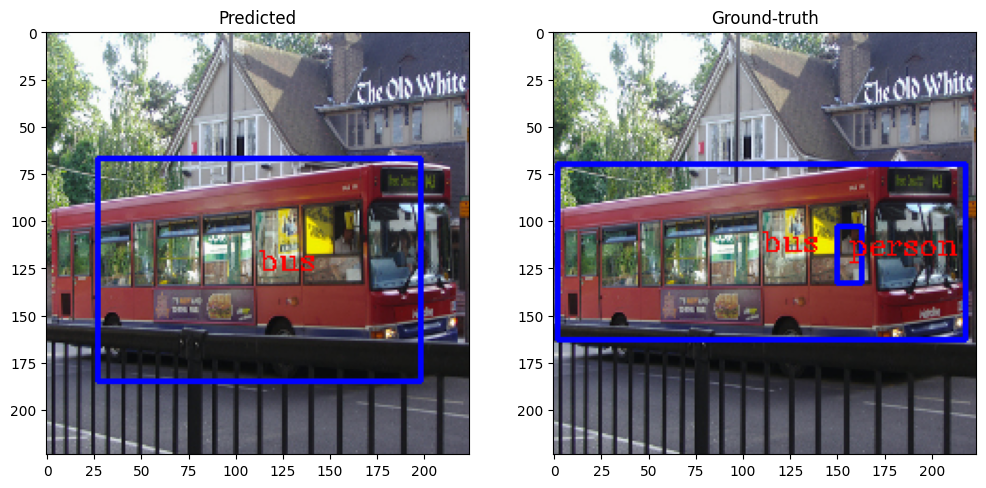

In [153]:
background_threshold = 0.5

i = 8
(x, bb_true, class_true) = val_dataset[i]
img_file = val_dataset.data_list[i].filename
model.eval()
class_hat, bb_hat = model(x.unsqueeze(0))

bb_hat = dt.invert_transformation(bb_hat.squeeze(0), anchors)
bb_hat = bb_hat * target_size

class_hat = class_hat.sigmoid().squeeze(0)
# Filtering with < since we want low probability of background
bb_hat = bb_hat[class_hat[:,0] < background_threshold, :]
bb_hat = bb_hat.detach().cpu().numpy()
class_hat = class_hat[class_hat[:,0] < background_threshold, :]
class_preds = class_hat[:, 1:]
if len(class_preds) > 0:
    prob, class_id = class_preds.max(1)
    prob = prob.detach().cpu().numpy()
    class_id += 1
    class_id = class_id.detach().cpu().numpy()
else:
    prob = []
output_bb = [PredBoundingBox(probability=prob[j],
                             class_id=class_id[j],
                             classname=id_cat[class_id[j]],
                             bounding_box=[bb_hat[j, 0], 
                                           bb_hat[j, 1], 
                                           bb_hat[j, 2], 
                                           bb_hat[j, 3]])
             for j in range(len(prob))]

output_bb = sorted(output_bb, key = lambda x: x.probability, reverse=True)
filtered_bb = non_max_suppression(output_bb)
example = val_data_list[:][i]
img_str = IMG_PATH + img_file
f, axs = plt.subplots(1, 2, figsize=(12, 12))

img_pred = display.read_img(img_str, target_size)
img_pred = display.draw_boxes(img_pred, [bb.bounding_box for bb in filtered_bb])
img_pred = display.draw_text(img_pred, [bb.classname for bb in filtered_bb], [bb.bounding_box for bb in filtered_bb])
axs[0].imshow(img_pred)
axs[0].set_title("Predicted")

img_gt = display.read_img(img_str, target_size)
img_gt = display.draw_boxes(img_gt, example.bounding_boxes)
img_gt = display.draw_text(img_gt, example.classnames, example.bounding_boxes)
axs[1].imshow(img_gt)
axs[1].set_title("Ground-truth")

plt.show()